In [116]:
'''测试'''
import numpy as np

mm = np.array([1,2,3])
pow(mm,2)

array([1, 4, 9], dtype=int32)

Harris opencv 的对应代码
cv2.cornerHarris(src, blockSize, ksize, k[, dst[, borderType]])
   参数类型
   src - 输入灰度图像，float32类型
    blockSize - 用于角点检测的邻域大小，就是上面提到的窗口的尺寸
    ksize - 用于计算梯度图的Sobel算子的尺寸
    k - 用于计算角点响应函数的参数k，取值范围常在0.04~0.06之间

注：Sobel算子是滤波算子的形式,利用快速卷积函数， 简单有效，因此应用广泛
    优点：方法简单、处理速度快,并且所得的边缘光滑
    缺点：Sobel算子并没有将图像的主体与背景严格地区分开来，换言之就是Sobel算子没有基于图像灰度进行处理
    原理：
    sobel算子的horizon垂直检测Sob_x：
        [[-1,0,1],
        [-2,0,2],
        [-1,0,1]]
    sobel算子的vertical水平检测 Sob_y：
        [[1,2,1],
        [0,0,0],
        [-1,-2,-1]]
    矩阵公式：
            Gx = Sob_x *img.data  Gy = Sob_y * img.data
            G的运算采用L2 范数,节约时间可用L1范数
            L2：G = np.sqrt(pow(Gx,2)+pow(Gy,2)
            L1：G = |Gx|+|Gy|
            得到梯度值,若G大于阈值threshold,则说明有角点
            再由 theta = 1/tan(Gy/Gx)得到梯度的方向
            若theta 角度为0 代表图像有纵向边缘

In [117]:
'''sobel算子的实现'''
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
'''Sober算子,初始化'''
sob_x ,sob_y= [[-1,0,1],[-2,0,2],[-1,0,1]], \
              [[1,2,1],[0,0,0],[-1,-2,-1]]

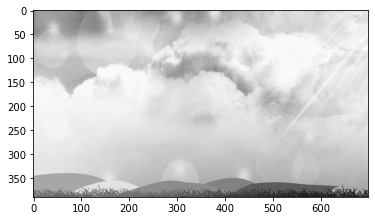

In [118]:
'''图片读取并灰度化'''
img1 = cv2.imread('figures/image1.jpeg') #读取通道为BGR
img1_gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY) #BGR通道转为Gray,
# 类型type(img1_gray)  numpy.ndarray,shape (390, 700)

plt.imshow(img1_gray,cmap='gray')
plt.show()

In [119]:
'''这里舍弃最外围的一圈像素点 实际sobel算子卷积了 388x698图片'''

# 切片操作，取第一个需要卷积的矩阵，其核心位置为【1，1】
d10 = img1_gray[0:10,0:10]
d1 = img1_gray[0:3,0:3]
sob_d1 = np.abs(np.sum(sob_x*d1)) +np.abs(np.sum(sob_y * d1))
d10,d1,f'最开始的卷积之后的值 = {sob_d1}'

(array([[135, 139, 143, 146, 148, 152, 156, 159, 161, 162],
        [135, 138, 142, 145, 148, 151, 155, 158, 161, 162],
        [134, 137, 142, 145, 147, 150, 154, 158, 161, 162],
        [134, 137, 141, 144, 147, 150, 154, 157, 161, 162],
        [134, 138, 142, 145, 147, 150, 155, 158, 161, 162],
        [136, 139, 143, 146, 148, 152, 156, 159, 161, 162],
        [137, 140, 144, 148, 150, 153, 157, 160, 161, 162],
        [138, 141, 145, 148, 151, 154, 158, 161, 161, 162],
        [144, 145, 146, 148, 150, 152, 154, 155, 160, 160],
        [144, 144, 145, 147, 148, 150, 152, 153, 160, 160]], dtype=uint8),
 array([[135, 139, 143],
        [135, 138, 142],
        [134, 137, 142]], dtype=uint8),
 '最开始的卷积之后的值 = 36')

In [120]:
'''定义一个卷积函数'''
def convolution_ndarray(kernal, data_gray):
    n, m = data_gray.shape  # (390, 700)
    img_new = np.zeros((n-2, m-2))
    for i in range(n-2 ):  # [0,387)
        temp_row = np.zeros(m-2)  # 700
        for j in range(m -2):  # [ 0,697)
            temp = data_gray[i:i + 3, j:j + 3]
            temp_row[j] = np.sum(np.multiply(kernal, temp))
        img_new[i] = temp_row
    return img_new



Gx = convolution_ndarray(sob_x,img1_gray)

Gy = convolution_ndarray(sob_y,img1_gray)
# L1范数
G_L1 = np.absolute(Gx) +np.absolute(Gy)
# L2范数
G_L2 = np.sqrt(pow(Gx,2)+pow(Gy,2))

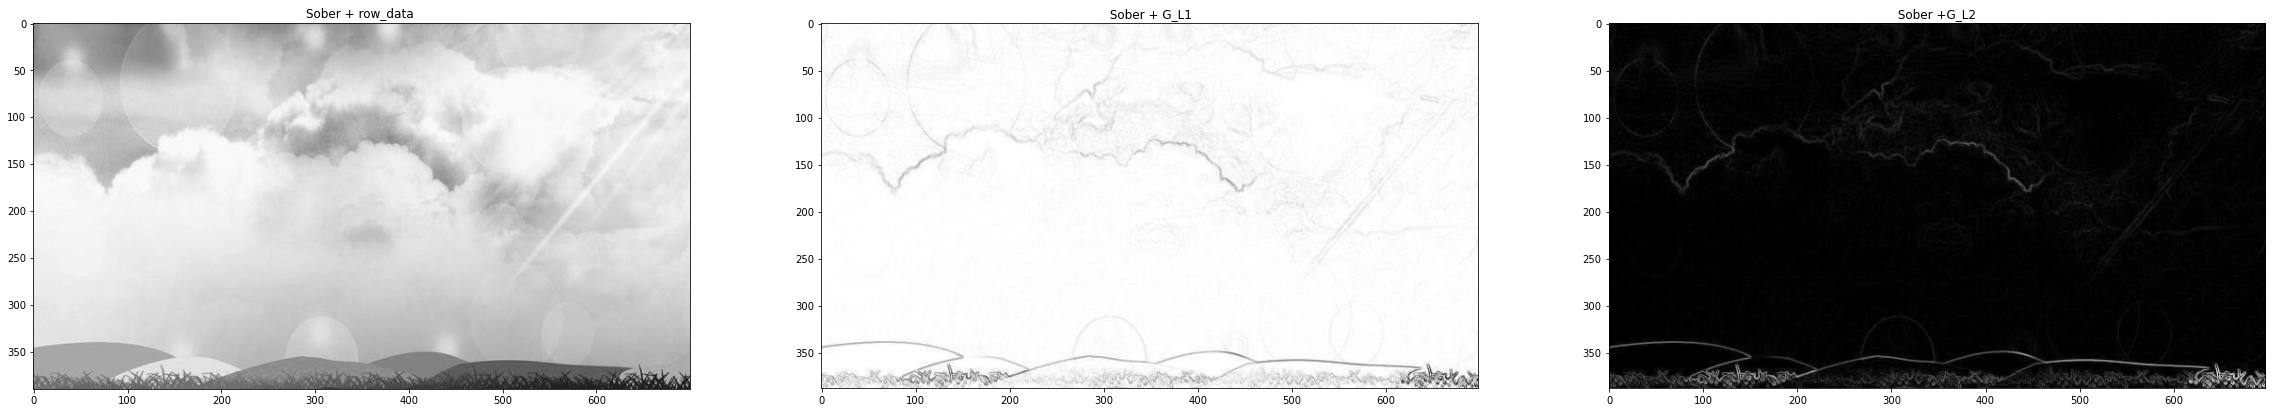

In [121]:
# 255矩阵

ones = np.ones(G_L1.shape)*255 #ones.shape (387, 697)


plt.figure(figsize=(40,40))
plt.subplot(131)
plt.imshow(img1_gray, cmap='gray')
plt.title('Sober + row_data ')

Color_Reversal_1 = ones -G_L1 #颜色反转
plt.subplot(132)
plt.imshow(Color_Reversal_1,cmap='gray')
plt.title(' Sober + G_L1')

Color_Reversal_2 = ones-G_L2    #颜色反转
plt.subplot(133)
plt.imshow(G_L2,cmap='gray')
plt.title(' Sober +G_L2 ')
plt.show()

采用opencv 封装的Harris 角点检测方法检测角点
图像的角点检测
检测图像中的角点（几条边相交的位置)
1.Harris角点检测 思想：边缘是在各个方向上都具有高密度变化的区域 算法基本思想是使用一个固定窗口在图像上进行任意方向上的滑动，比较滑动前与滑动后两种情况，窗口中的像素灰度变化程度，如果存在任意方向上的滑动，都有着较大灰度变化，那么我们可以认为该窗口中存在角点。
角点的特征：
    >轮廓之间的交点；
    >对于同一场景，即使视角发生变化，通常具备稳定性质的特征；
    >该点附近区域的像素点无论在梯度方向上还是其梯度幅值上有着较大变化;
    >就是一阶导数(即灰度图的梯度)中的局部最大所对应的像素点就是角点.
harris 角点检测的步骤
    1.当窗口（小的图像片段）同时向 x 和 y 两个方向移动时，计算窗口内部的像素值变化量 d f(x,y) ;
    2.对于每个窗口，都计算其对应的一个角点激活函数 G;
    3.然后对该函数进行阈值处理，如果 G > threshold，表示该窗口对应一个角点特征.

2.Shi-Tomasi角点检测
    Harris角点检测的改进版
    Shi-Tomasi 发现，角点的稳定性其实和矩阵 M 的较小特征值有关


OpenCV 中的 Harris 角点检测
Open 中的函数 cv2.cornerHarris() 可以用来进行角点检测。参数如下:
　　• img - 数据类型为 float32 的输入图像。
　　• blockSize - 角点检测中要考虑的领域大小。
　　• ksize - Sobel 求导中使用的窗口大小
　　• k - Harris 角点检测方程中的自由参数,取值参数为 [0,04,0.06].
————————————————
原文链接：https://blog.csdn.net/fuhao7i/article/details/111176488


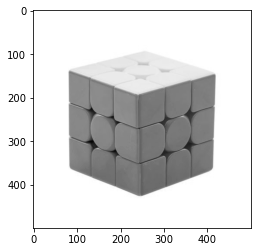

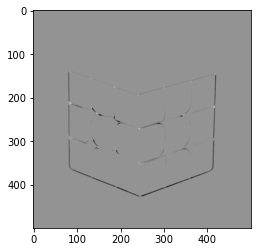

(500, 500)

In [127]:
magic_cube= cv2.imread('figures/magic_cube.jpg')  #cv2读取是BGR格式
magic_cube_gray = cv2.cvtColor(magic_cube,cv2.COLOR_BGR2GRAY)
corners = cv2.cornerHarris(magic_cube_gray,3,3,0.06) #shape (500, 500)

plt.imshow(magic_cube_gray,cmap ='gray')
plt.show()
plt.imshow(corners,cmap='gray')
plt.show()
'''如下图所示，直接显示的检测效果并不理想，cube的上面灰度值与255较为接近，偏差不明显，故而使用threshold'''
corners.shape

In [123]:
'''对该函数进行阈值处理，如果 G > threshold，表示该窗口对应一个角点特征.'''
threshold= 0.1*corners.max()
flag = corners > threshold


'''方法1，由np.where 直接找到 符合条件的array 下标'''
# where(condition, [x, y])
x,y = np.where(flag) #返回tuple 返回了一个基于原本数据的地址索引 type() -> 2
corners_data1 = []
for i,j in zip(x,y):
    corners_data1.append(corners[i][j])
'''方法2，由 统计学习的数学运算方法传入一个由True，false组成的flag，
直接得到一个符合条件的一维数据'''
corners_data2 = corners[flag]


'''测试data_index 所指向的数据是否和corners_data所记录的符合的数据一致'''
corners_data1 == corners_data2
#数据比对均为True，说明由方法1和方法2获得的数据一样

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

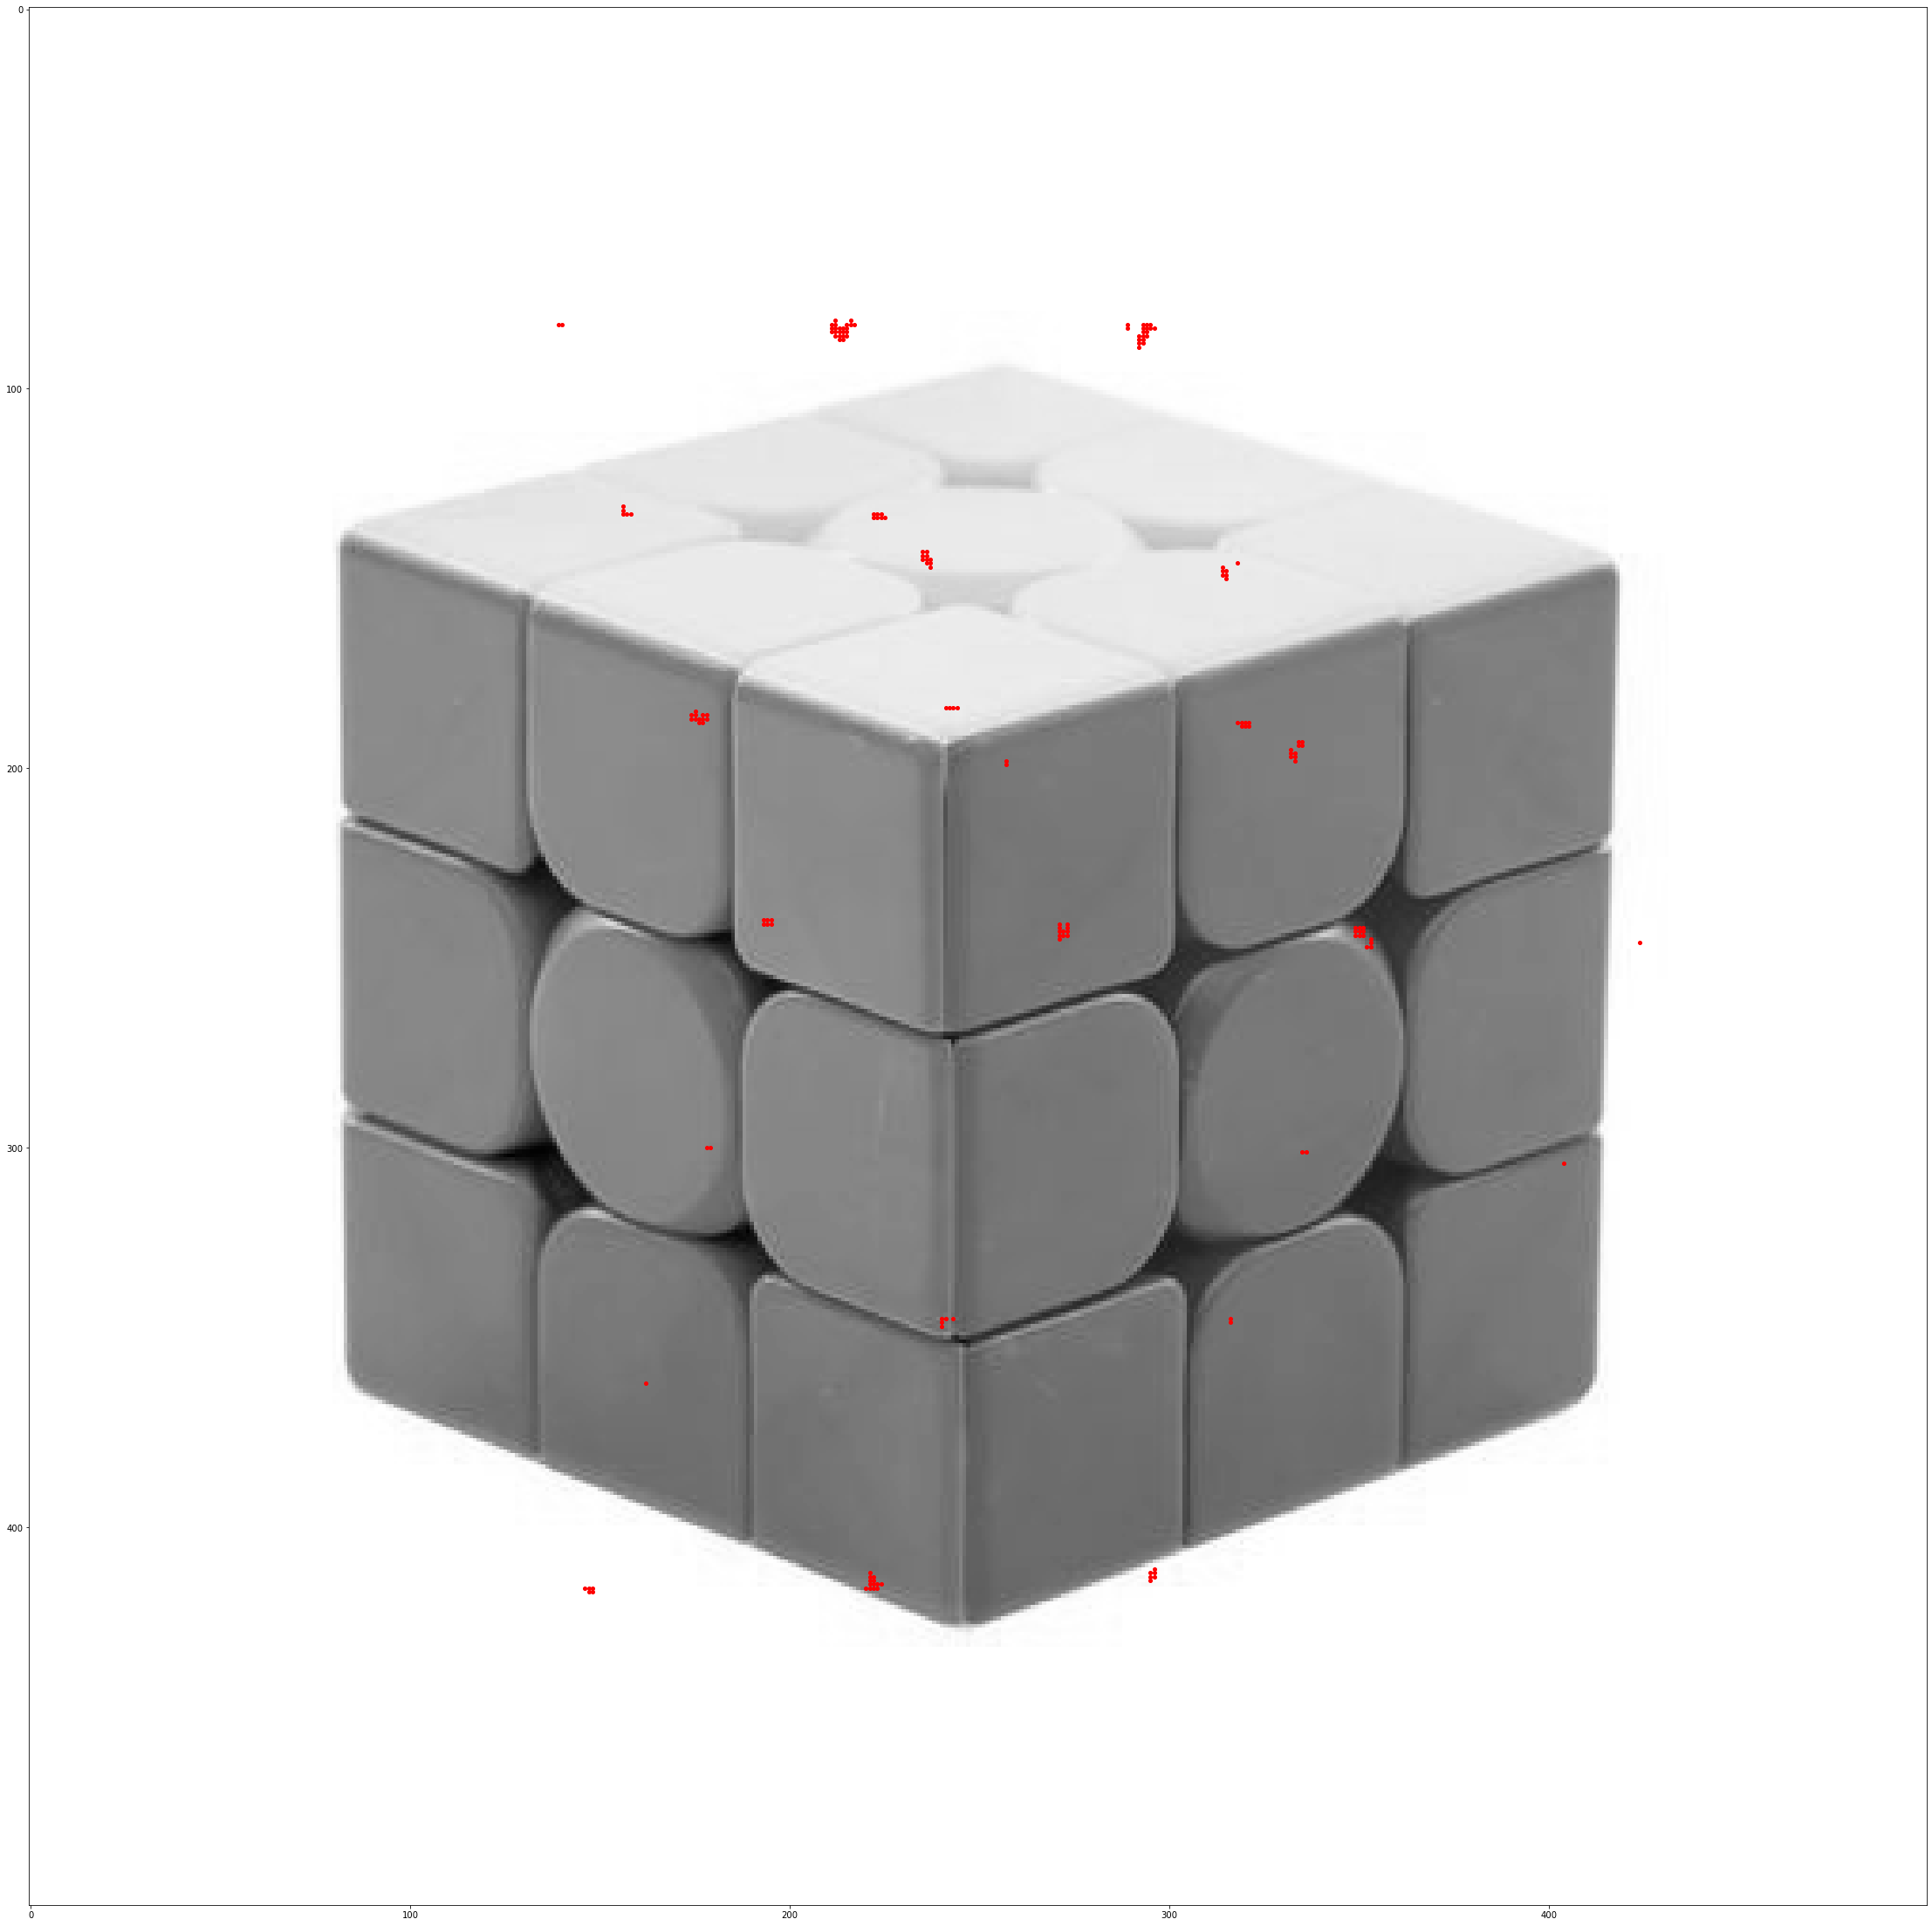

In [133]:
'''对于方法2的解释说明'''
a = np.array([[1,2,3],[1,2,3]])
flag1 = np.array([[True,True,True],[False,True,False]])
b = a[flag1] #这种方法只是返回合格的数据，但并没有原始数据所在的下标，且形状为1维，适合label标签的选取分类

'''plot 绘制角点'''
plt.figure(figsize=(40,40))
plt.imshow(magic_cube_gray,cmap='gray')
plt.plot(x,y,'o',c= 'r',markersize = 4)

In [ ]:
'''使用Harris角点检测技术寻找角点'''
#1.使用cv2.threshold函数改变角点图中大于最大值10%处的像素值。我们将阈值图像转换为一个8位的无符号整数
ret,corners = cv2.threshold(corners,0.1*corners.max(),255,0)
corners = np.uint8(corners)

#2.使用cv2.connectedComponentsWithStats函数计算角点的中心点
ret,labels,stats,centroids = cv2.connectedComponentsWithStats(corners)

#3.我们把中心点连同停止标准一起传递给cv2.cornerSubPix函数。这个停止标准定义了何时停止迭代的条件。
criteria = (cv2.TermCriteria_EPS + cv2.TermCriteria_MAX_ITER,100,0.001)
corners = cv2.cornerSubPix(img1_gray,float(centroids),(5,5),(-1,-1),criteria)

#4.把这些新的角点转换回整数类型：
corners = np.int0(corners)
centroids = np.int0(centroids)

In [ ]:
#最后，我们可以画出这些新的点，并比较视觉上的变化：

cornert_plot = [corners[:,0],corners[: ,1]]
